# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

## Solution

### Read in image

Image Dimensions:  (303, 384)  Image Datatype:  uint8


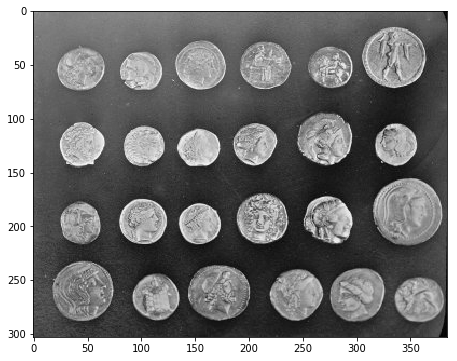

In [1]:
%matplotlib inline
import skimage.data as data
import matplotlib.pyplot as plt
coin_im = data.coins()
plt.figure(figsize=(10,6))
plt.imshow(coin_im,cmap='gray')
print('Image Dimensions: ',coin_im.shape,' Image Datatype: ',coin_im.dtype)
# Note the image is grayscale and unsigned byte data

### Equalize image

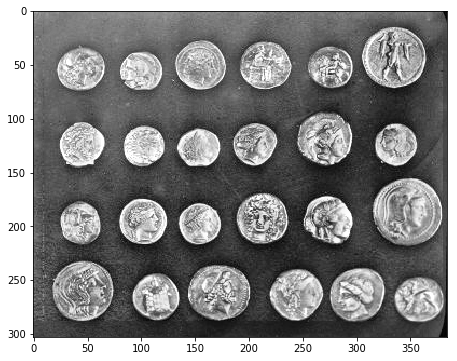

In [57]:
from skimage import exposure
coin_im_equalized = exposure.equalize_adapthist(coin_im,kernel_size = [20,20])
plt.figure(figsize=(10,6))
plt.imshow(coin_im_equalized,cmap='gray')

### Threshold Image

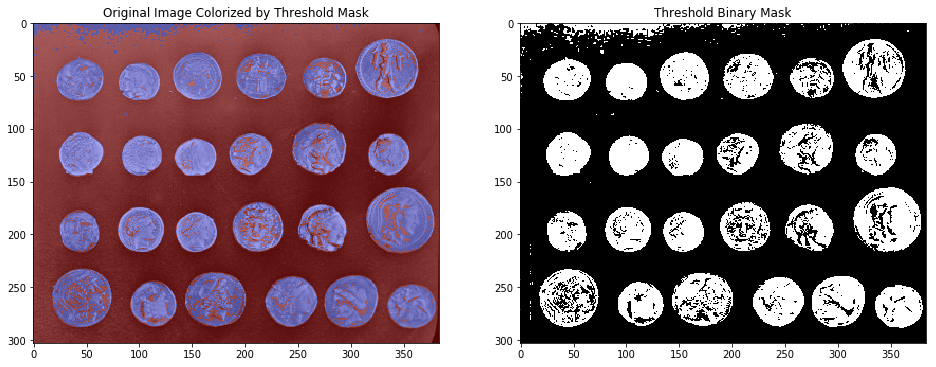

In [58]:
from skimage import filters
from skimage.color import label2rgb as l2rgb
import numpy as np
# Identify threshold value to define background
threshold_val = filters.threshold_otsu(coin_im_equalized)
# Return image with background pixels set to 0
foreground_mask = coin_im_equalized >= threshold_val
# Plot thresholded mask on top of original image
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(l2rgb(foreground_mask,coin_im))
plt.title('Original Image Colorized by Threshold Mask')
plt.subplot(122)
plt.title('Threshold Binary Mask')
plt.imshow(foreground_mask,cmap='gray')

### Remove Objects Touching the Boundary

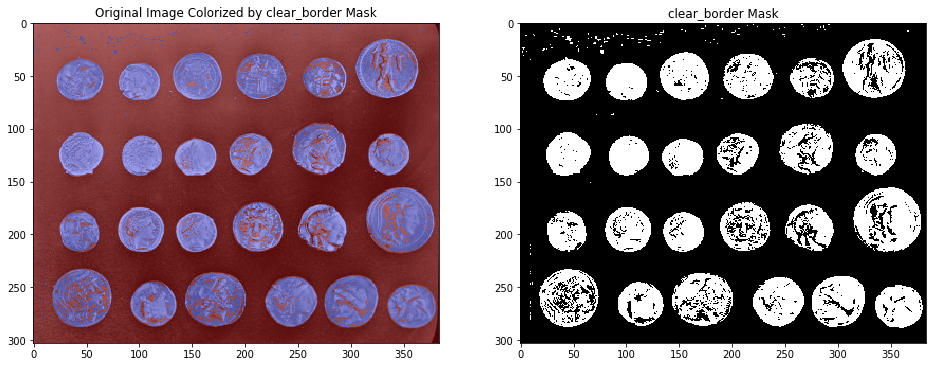

In [59]:
from skimage import segmentation
clear_boundary_mask = segmentation.clear_border(foreground_mask,buffer_size=1)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title('Original Image Colorized by clear_border Mask')
plt.imshow(l2rgb(clear_boundary_mask,coin_im))
plt.subplot(122)
plt.title('clear_border Mask')
plt.imshow(clear_boundary_mask,cmap='gray')

### Apply Morphological Closing to remove small spots

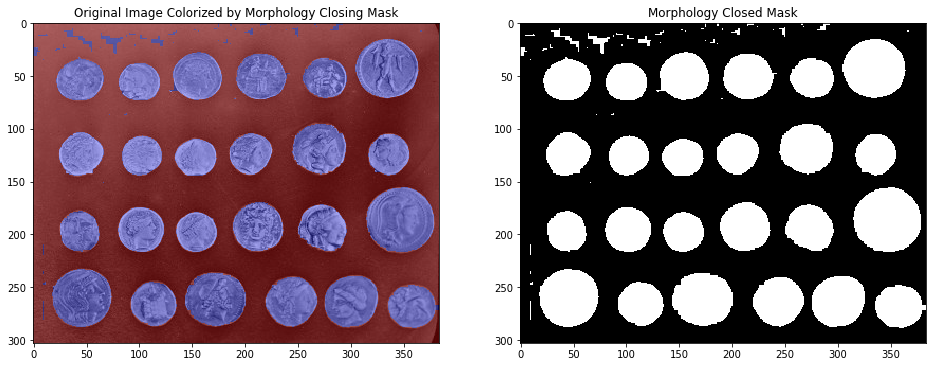

In [60]:
from skimage.morphology import closing
# Remove dark spots and connect bright cracks
closed_mask = closing(clear_boundary_mask,selem=np.ones((7,7)))
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title('Original Image Colorized by Morphology Closing Mask')
plt.imshow(l2rgb(closed_mask,coin_im))
plt.subplot(122)
plt.title('Morphology Closed Mask')
plt.imshow(closed_mask,cmap='gray')

### Label Regions in image. For each, extract centroid position, area and eccentricity.

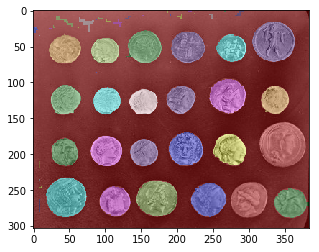

In [90]:
from skimage.measure import label,regionprops 

# segment image
label_mask = label(closed_mask)
labels = regionprops(label_mask,intensity_image=coin_im) 

# plot labelled images:
plt.imshow(l2rgb(label_mask,coin_im))

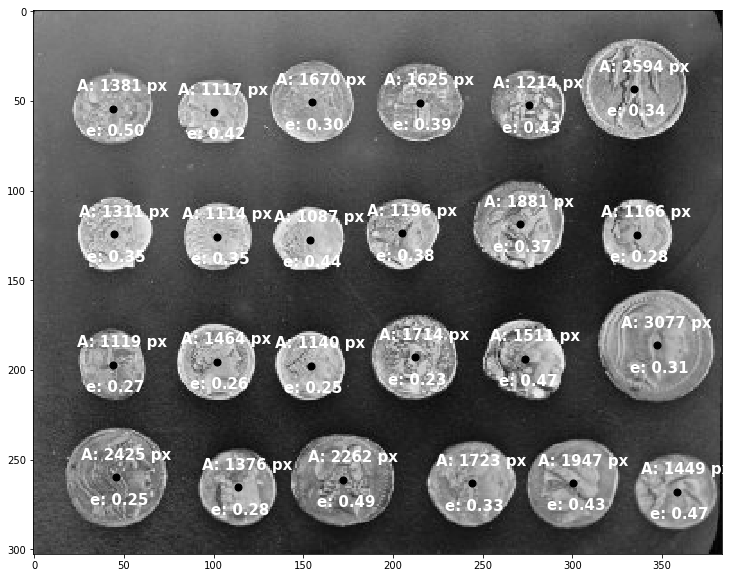

In [92]:
centroids,areas,eccentricity = [],[],[]
for el in np.arange(len(labels)) : 
    centroids.append(labels[el].centroid)
    areas.append(labels[el].area)
    eccentricity.append('%0.2f' % labels[el].eccentricity)
    
# Sort by area and take the 20 largest since there are 20 coins
inds = np.argsort(areas).astype(int)[-24:]
coin_centroids = np.array(centroids)[inds]
coin_areas = np.array(areas)[inds]
coin_eccs = np.array(eccentricity)[inds]

# Plot info on top of original image by coin centroid.
plt.figure(figsize=(15,10))
plt.imshow(coin_im,cmap='gray')
for i in np.arange(len(inds)) : 
    plt.scatter(coin_centroids[i][1],coin_centroids[i][0],marker='o',s=50,color='black')
    plt.text(coin_centroids[i][1]-20,coin_centroids[i][0]-10,'A: '+str(coin_areas[i])+' px',
             fontdict={'color':'white','fontsize':15,'weight':'bold'})
    plt.text(coin_centroids[i][1]-15,coin_centroids[i][0]+15,'e: '+str(coin_eccs[i]),
             fontdict={'color':'white','fontsize':15,'weight':'bold'})

A : Area in pixels

e : eccentricity: 0 -> circle, >0 -> more eliptical

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.